Loading Network
MC-CNN model loaded
Start Detecting
/root/caltech/data/images
/root/caltech/data/images/set06_V*
/root/caltech/data/images/set07_V*
/root/caltech/data/images/set08_V*
/root/caltech/data/images/set09_V*
/root/caltech/data/images/set10_V*
set07_V006_29.jpg
39.8166542053, 180.619995117, 19.2777118683, 49.8968772888
411.800811768, 176.84526062, 19.3720703125, 43.3156929016
461.040679932, 175.491714478, 16.8109436035, 46.7717170715
518.783081055, 164.029647827, 21.5060062408, 48.6715660095
3.14577031136, 188.926574707, 14.5363588333, 44.9222412109
set07_V006_59.jpg
488.278411865, 159.089645386, 20.3460083008, 51.2739982605
601.402954102, 145.08026123, 25.7425231934, 58.1113624573
522.101318359, 153.613143921, 16.7142791748, 50.0370903015
510.138397217, 161.394866943, 17.7368087769, 48.0259056091
412.384063721, 99.8336410522, 24.5402202606, 54.4527549744
set07_V006_89.jpg
534.347717285, 148.625549316, 23.5673236847, 66.9199142456
548.461120605, 162.584091187, 19.5302505493, 5

KeyboardInterrupt: 

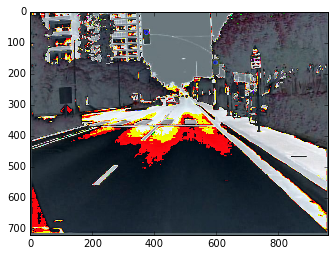

In [45]:
import sys
import os
import math
import numpy as np
import json
from os import listdir
from os.path import isfile, join
sys.path.insert(0, "../../")
from nms.cpu_nms import cpu_nms
import glob
import cv2
import argparse
import re
import time
from scipy.misc import imread
import matplotlib.pyplot as plt
import matplotlib
sys.path.insert(0, "../../python/")
import caffe
%matplotlib inline
matplotlib.interactive(True)
from __future__ import division



class Timer(object):
    """A simple timer."""
    def __init__(self):
        self.total_time = 0.
        self.calls = 0
        self.start_time = 0.
        self.diff = 0.
        self.average_time = 0.

    def tic(self):
        # using time.time instead of time.clock because time time.clock
        # does not normalize for multithreading
        self.start_time = time.time()

    def toc(self, average=True):
        self.diff = time.time() - self.start_time
        self.total_time += self.diff
        self.calls += 1
        self.average_time = self.total_time / self.calls
        if average:
            return self.average_time
        else:
            return self.diff




CALTECH_DATA_PATH = "/root/caltech/data/"
IMG_PATH = os.path.join(CALTECH_DATA_PATH + "images")



def parse_args():
    """
    Parse input arguments
    """
    parser = argparse.ArgumentParser(description='Test a MSCNN network')
    parser.add_argument('--gpu', dest='gpu_id', help='GPU id to use',
                        default=0, type=int)
    parser.add_argument('--def', dest='prototxt',
                        help='prototxt file defining the network',
                        default='mscnn-7s-720-pretrained/mscnn_deploy.prototxt', type=str)
    parser.add_argument('--net', dest='caffemodel',
                        help='model to test',
                        default='mscnn-7s-720-pretrained/mscnn_caltech_train_2nd_iter_20000.caffemodel'\
                        , type=str)
    
    parser.add_argument('--detection', dest='dt_name',  help='model to test', default='detection_1', type=str)
    
    
    if len(sys.argv) == 1:
        parser.print_help()
        sys.exit(1)

    args = parser.parse_args()
    return args


def filter_proposals(proposals, threshold=-10):
    #Bug 1 Fixed
    keeps =  (proposals[:, -1] > threshold) & (proposals[:, 2] != 0) & (proposals[:, 3] != 0)
 
    return keeps


def im_normalize(im, target_size, mu=[104, 117, 123] ):
    n_im = cv2.resize(im, target_size).astype(np.float32)
  
  
    n_im -= mu
    plt.imshow(n_im)
    #I should do a numpy transpose in here
    n_im = np.swapaxes(n_im, 0,2)
    n_im = np.swapaxes(n_im, 1,2)
    n_im = np.array([n_im])
    #print(n_im.shape)
    #Substracts mu from testing-BGR image
    

    return n_im


def bbox_denormalize(bbox_pred, proposals, ratios, orgW, orgH):
    
    ctr_x = proposals[:,0]+0.5*proposals[:,2]
    ctr_y = proposals[:,1]+0.5*proposals[:,3]
    tx = bbox_pred[:,0] *proposals[:,2] + ctr_x
    ty = bbox_pred[:,1] *proposals[:,3] + ctr_y
    tw = proposals[:,2] * np.exp(bbox_pred[:,2])
    th = proposals[:,3] * np.exp(bbox_pred[:,3])

    #Fix Bug 2
    tx -= tw/2 
    ty -= th/2
    tx /= ratios[0] 
    tw /= ratios[0]
    ty /= ratios[1] 
    th /= ratios[1]

    tx[tx < 0] = 0
    ty[ty < 0] = 0
    #Fix Bug 3
    tw[tw > (orgW - tx)] = (orgW - tx[tw > (orgW - tx)])
    th[th > (orgH - ty)] = (orgH - ty[th > (orgH - ty)])
    
    new_boxes = np.hstack((tx[:, None], ty[:, None], tw[:, None], th[:, None])).astype(np.float32).reshape((-1, 4)) #suspecious
    
    return new_boxes


def get_confidence(cls_pred):
    exp_score = np.exp(cls_pred)
    sum_exp_score = np.sum(exp_score, 1)
    confidence = exp_score[:, 1] / sum_exp_score
    
    return confidence



#mu is the mean of BGR
def im_detect(net, file_path, target_size= (960, 720)):
       
 
    im = cv2.imread(file_path)
    orgH, orgW, _ = im.shape
    ratios = (target_size[0]/orgW, (target_size[1]/orgH ))
    im = im_normalize(im, target_size)
    
    #Feedforward
 
    net.blobs['data'].data[...] = im 
    output = net.forward()
    
    bbox_pred = output['bbox_pred']
    proposals = output['proposals_score'].reshape((-1,6))[:,1:]  #suspecious
    proposals[:,2] -=   proposals[:,0]
    proposals[:,3] -=   proposals[:,1]
    cls_pred = output['cls_pred']
    
    
    keeps = filter_proposals(proposals)
    bbox_pred =  bbox_pred[keeps]
    cls_pred = cls_pred[keeps]
    proposals = proposals[keeps]
    
    pedestrian_boxes = bbox_pred[:,4:8]
    boxes = bbox_denormalize(pedestrian_boxes, proposals, ratios, orgW, orgH)

    #Denormalize the confidence 
    
    confidence = get_confidence(cls_pred)
   
    
    return confidence, boxes
    


def nms(dets, thresh):
    
    if dets.shape[0] == 0:
        return []
    new_dets = np.copy(dets)
    new_dets[:,2] += new_dets[:,0]
    new_dets[:,3] += new_dets[:,1]

    
    
   
    return cpu_nms(new_dets, thresh)
  

def write_caltech_results_file(net):


    # The follwing nested fucntions are for smart sorting
    def atoi(text):
        return int(text) if text.isdigit() else text

    def natural_keys(text):
        '''
        alist.sort(key=natural_keys) sorts in human order
        http://nedbatchelder.com/blog/200712/human_sorting.html
        (See Toothy's implementation in the comments)
        '''
        return [ atoi(c) for c in re.split('(\d+)', text) ]

    def insert_frame(target_frames, file_path,start_frame=29, frame_rate=30):
        file_name = file_path.split("/")[-1]
        set_num, v_num, frame_num = file_name[:-4].split("_")
        if int(frame_num) >= start_frame and int(frame_num) % frame_rate == 29:
            target_frames.setdefault(set_num,{}).setdefault(v_num,[]).append(file_path)
            return 1
        else:
            return 0

 
    
    def detect(file_path,  NMS_THRESH = 0.3):
        

        confidence, bboxes = im_detect(net, file_path)      
        dets = np.hstack((bboxes,confidence[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        return dets[keep, :]


    def get_target_frames(image_set_list,  image_path):
        target_frames = {}
        total_frames = 0 
        for set_num in image_set_list:
            file_pattern = "{}/set{}_V*".format(image_path,set_num)
            print(file_pattern)
            file_list = sorted(glob.glob(file_pattern), key=natural_keys)
            for file_path in file_list:
                total_frames += insert_frame(target_frames, file_path)

        return target_frames, total_frames 

    def render_detections(v_num, file_list, max_proposal=100, thresh=0):

     
        for file_index, file_path in enumerate(file_list):
            file_name = file_path.split("/")[-1]
            set_num, v_num, frame_num = file_name[:-4].split("_")
            frame_num = str(int(frame_num) +1)

            
            dets = detect(file_path)
        
        
            #inds = np.where(dets[:, -1] >= thresh)[0]
            inds = np.argsort(-dets[:, -1])[:5]
            print(os.path.basename(file_path))
            #print("{} detections smaller than 0".format(dets.shape[0] - inds.shape[0]))
     
            for i in inds:
                bbox = dets[i, :4]
                score = dets[i, -1]

                x = bbox[0]
                y = bbox[1] 
                width = bbox[2]  
                length =  bbox[3] 
                print("{}, {}, {}, {}".format(x,y,width,length))
          
            

   



    image_set_list = ["06", "07" , "08", "09", "10"]
    target_frames, total_frames = get_target_frames(image_set_list,  IMG_PATH)



    for set_num in target_frames:
      
        for v_num, file_list in target_frames[set_num].items():
            render_detections(v_num, file_list)
           
      


                
if __name__ == "__main__":
    sys.argv = ["","--gpu", "3"]
    args = parse_args()
    global GPU_ID
    global DETECTION_NAME
    
    caffe.set_mode_gpu()
    caffe.set_device(args.gpu_id)
    GPU_ID = args.gpu_id
    
    DETECTION_NAME = args.dt_name
    
    
    
    
    print("Loading Network")
    net = caffe.Net(args.prototxt, args.caffemodel, caffe.TEST)
    #net = {}
    print("MC-CNN model loaded")
    print("Start Detecting")
    print(IMG_PATH)
    write_caltech_results_file(net)                 

    

In [ ]:
im = cv2.imread("/root/data/caltech-pedestrian-dataset-converter/data/images/set07_V006_29.jpg")
im = cv2.resize(im, (960,720))
im = im.astype(np.float32)
plt.imshow(im)